완성된 데이터셋을 가지고 feature selection을 하려고 한다. 

In [2]:
import pandas as pd
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import matplotlib.pyplot  as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error as mse
import xgboost as xgb
from sklearn.model_selection import KFold

In [146]:
data_lbl.head()

,acc_id,temp_cnt_x,private_shop,level_x,party_exp,pledge_cnt,random_attacker_cnt_x,random_defender_cnt_x,same_pledge_cnt_x,etc_cnt_x,...,pledge_rank_4,amount_spent_1,amount_spent_2,amount_spent_3,amount_spent_4,pred,survival_time,amount_spent_y,secession,total_spent
0,2,0.000000,84.900753,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0,64,0.000000,0,0.000000
1,5,0.479728,0.000000,173.0,0.695285,0.000000,0.000000,0.000000,0.000000,0.000000,...,66814.0,0.000000,0.000000,0.000000,0.000000,1,60,0.000000,1,0.000000
2,8,3.837822,0.000000,1922.0,0.000000,0.128368,4.270875,0.000000,0.000000,0.225223,...,22331.0,1.056123,0.000000,0.000000,0.348521,0,64,0.020310,0,1.299843
3,17,3.358094,0.000000,687.0,8.823094,0.000000,0.000000,2.366129,12.398273,0.563058,...,2673.0,0.000000,0.000000,0.000000,0.000000,0,64,0.070642,0,4.521100
4,20,0.959456,2.917510,930.0,0.110339,1.540422,0.000000,2.366129,0.000000,21.621413,...,2500.0,0.000000,0.070408,0.826123,0.000000,0,64,0.052137,0,3.336752


In [9]:
data = pd.read_csv('./merge_all_flatten.csv')
train_label = pd.read_csv('./train_label_add.csv')
train_label = train_label.sort_values('acc_id')

In [11]:
del data['minus']
del data['plus']

In [40]:
data_lbl = pd.merge(data, train_label, on='acc_id')
data_63_lbl = data_lbl[data_lbl['survival_time']!=64]
data_63 = data_63_lbl.drop(['total_spent','survival_time','secession','amount_spent_y'],axis=1)

In [67]:
# 총결제량 20 초과
over_20 = pd.merge(data, train_label[train_label['total_spent']>20], on='acc_id', how = 'inner')
over_10 = pd.merge(data, train_label[train_label['total_spent']>10], on='acc_id', how = 'inner')

# 총결제량 20 이하  
under_20 = pd.merge(data, train_label[(train_label['total_spent']<=20) & (train_label['total_spent']>0)], on='acc_id', how = 'inner')

# 총결제량 20 미만 10 이상
between_20 = pd.merge(data, train_label[(train_label['total_spent']<20) & (train_label['total_spent']>=10)], on='acc_id', how = 'inner')
between_10 = pd.merge(data, train_label[(train_label['total_spent']<10) & (train_label['total_spent']>0)], on='acc_id', how = 'inner')

spent_0 = pd.merge(data, train_label[train_label['total_spent']==0], on='acc_id', how = 'inner')


In [6]:
over_20.describe().T
# 잔존자일 확률이 매우 높음

,count,mean,std,min,25%,50%,75%,max
acc_id,1765.0,65592.235127,37223.290797,38.000000,33519.000000,64852.000000,97583.000000,130473.000000
temp_cnt_x,1765.0,5.526790,7.579230,0.000000,0.959456,2.878367,6.716189,86.830725
private_shop,1765.0,1.825922,9.668423,0.000000,0.000000,0.000000,0.000000,89.644949
level_x,1765.0,931.048725,718.709366,0.000000,486.000000,653.000000,1099.000000,4201.000000
party_exp,1765.0,1.317461,8.834337,0.000000,0.002798,0.066659,0.299663,239.785971
pledge_cnt,1765.0,50.202114,133.835115,0.000000,0.000000,0.192553,19.640378,1444.658933
random_attacker_cnt_x,1765.0,4.925178,22.889205,0.000000,0.000000,0.000000,0.000000,396.337246
random_defender_cnt_x,1765.0,5.881138,13.251800,0.000000,0.000000,1.183064,5.915322,191.656447
same_pledge_cnt_x,1765.0,9.254801,28.077546,0.000000,0.000000,0.000000,6.199136,452.536947
etc_cnt_x,1765.0,21.326262,50.140069,0.000000,0.337835,3.378346,19.143959,629.498432


In [9]:
between_20.describe().T

,count,mean,std,min,25%,50%,75%,max
acc_id,3774.0,65814.658983,37301.265543,21.000000,33905.000000,66376.500000,97568.250000,130447.000000
temp_cnt_x,3774.0,4.677155,6.907458,0.000000,0.959456,2.398639,5.756733,169.343901
private_shop,3774.0,1.355138,8.792439,0.000000,0.000000,0.000000,0.000000,89.875387
level_x,3774.0,797.037361,591.303615,0.000000,472.000000,611.000000,905.750000,3747.000000
party_exp,3774.0,2.124833,9.556703,0.000000,0.002261,0.066181,0.414799,159.631787
pledge_cnt,3774.0,32.706276,103.887204,0.000000,0.000000,0.064184,8.151399,1398.061173
random_attacker_cnt_x,3774.0,3.776567,22.899818,0.000000,0.000000,0.000000,0.000000,600.200369
random_defender_cnt_x,3774.0,4.429752,10.427472,0.000000,0.000000,1.183064,4.732258,149.066125
same_pledge_cnt_x,3774.0,7.263535,24.281601,0.000000,0.000000,0.000000,0.000000,502.130037
etc_cnt_x,3774.0,15.878911,44.949069,0.000000,0.225223,2.364842,11.486376,754.497226


In [1170]:
a = over_20.describe().T
a.to_csv('./over20desc.csv')

In [7]:
spent_0.describe().T
# 쓰는 돈은 많고 들어오는 돈은 적은 편
# 

,count,mean,std,min,25%,50%,75%,max
acc_id,16438.0,65141.849982,37439.589286,2.000000,32906.750000,65143.500000,97334.000000,1.304680e+05
temp_cnt_x,16438.0,2.230159,23.429911,0.000000,0.000000,0.479728,1.439183,1.438224e+03
private_shop,16438.0,20.912242,35.515023,0.000000,0.000000,0.000000,43.768273,9.163435e+01
level_x,16438.0,335.113517,307.479562,0.000000,56.000000,355.000000,448.000000,4.783000e+03
party_exp,16438.0,7.925201,28.203716,0.000000,0.000000,0.000000,0.145474,2.935522e+02
pledge_cnt,16438.0,0.915404,17.078013,0.000000,0.000000,0.000000,0.000000,1.196330e+03
random_attacker_cnt_x,16438.0,0.323039,4.378481,0.000000,0.000000,0.000000,0.000000,3.023780e+02
random_defender_cnt_x,16438.0,4.389315,15.023003,0.000000,0.000000,0.000000,1.183064,3.028645e+02
same_pledge_cnt_x,16438.0,0.408046,3.645023,0.000000,0.000000,0.000000,0.000000,1.425801e+02
etc_cnt_x,16438.0,3.487717,17.574578,0.000000,0.000000,0.000000,1.013504,5.623820e+02


In [21]:
datal =pd.merge(data, train_label, on='acc_id')
datar = datal.corr()
datar['source_merchant_ratio'].sort_values(ascending=False)

source_merchant_ratio        1.000000
hour_s                       0.671193
hour_mean                    0.568335
target_merchant_ratio        0.393188
hour_t                       0.307832
quest_exp_count              0.222610
game_money_change_count      0.209813
day_sum                      0.205293
private_shop_count           0.201344
rich_monster_count           0.195491
survival_time                0.192234
private_shop                 0.191314
playtime_count               0.191126
char_count                   0.191126
day_count                    0.191126
private_shop_3               0.191062
private_shop_4               0.191015
private_shop_2               0.189976
rich_monster_2               0.189404
private_shop_1               0.186010
target_count                 0.185582
minuss                       0.178800
merchant                     0.177365
22                           0.176700
18                           0.169319
21                           0.166787
fishing_coun

In [12]:
over = over_20.corr()
over['survival_time'].sort_values(ascending=False)

survival_time              1.000000
game_money_change_count    0.413262
npc_kill_count             0.408103
solo_exp_count             0.404673
day_sum                    0.390102
24                         0.366167
playtime_count             0.362426
char_count                 0.362426
day_count                  0.362426
level_max                  0.350573
quest_exp_count            0.320321
25                         0.312654
day_y                      0.302160
log_in_freq                0.294291
pluss                      0.292444
26                         0.288328
login_clt                  0.287047
num_opponent_count         0.271721
27                         0.270330
17                         0.264675
21                         0.263320
npc_kill_1                 0.262870
party_exp_count            0.261426
6                          0.260635
rich_monster_count         0.260348
18                         0.259556
19                         0.258173
5                          0

In [16]:
between =  between_20.corr()
between['survival_time'].sort_values(ascending=False)

survival_time              1.000000
game_money_change_count    0.347609
day_sum                    0.339233
solo_exp_count             0.326169
npc_kill_count             0.321448
playtime_count             0.320101
day_count                  0.320101
char_count                 0.320101
quest_exp_count            0.288196
playtime_4                 0.280253
playtime_3                 0.279960
fishing_count              0.268267
log_in_freq                0.260286
day_y                      0.255076
17                         0.253198
login_clt                  0.253102
playtime_2                 0.251572
19                         0.248161
20                         0.246951
party_exp_count            0.245872
24                         0.244675
23                         0.238173
playtime_1                 0.236648
16                         0.236438
27                         0.235844
18                         0.234906
25                         0.234853
playtime_clt               0

In [15]:
no_spent = spent_0.corr()
no_spent['total_spent'].sort_values(ascending=False)

acc_id                      NaN
class                       NaN
temp_cnt                    NaN
private_shop                NaN
level                       NaN
party_exp                   NaN
pledge_cnt                  NaN
random_attacker_cnt         NaN
random_defender_cnt         NaN
same_pledge_cnt             NaN
etc_cnt                     NaN
num_opponent                NaN
playtime                    NaN
npc_kill                    NaN
solo_exp                    NaN
quest_exp                   NaN
rich_monster                NaN
death                       NaN
revive                      NaN
exp_recovery                NaN
fishing                     NaN
game_money_change           NaN
enchant_count               NaN
forgive                     NaN
pledge_cnt_count            NaN
random_attacker_cnt_count   NaN
random_defender_cnt_count   NaN
temp_cnt_count              NaN
same_pledge_cnt_count       NaN
etc_cnt_count               NaN
                             ..
C_2     

In [136]:
VALID = True
if VALID == True:

    tr_data = xgb.DMatrix(X_train, y_train)
    #va_data = xgb.DMatrix(X_valid, y_valid)

    #del X_train, X_valid, y_train, y_valid  ; gc.collect()

    #watchlist = [(tr_data, 'train'), (va_data, 'valid')]

    model = xgb.train(params, tr_data, 500, maximize=False, 
                      verbose_eval=50)

-----------

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data[data.columns[1:]], train_label['secession'], test_size=0.1, random_state=42)

In [32]:
from sklearn.multiclass import OneVsRestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import ExtraTreesClassifier

np.random.seed(42)

# eval_set = [(X_train, y_train), (X_valid, y_valid)]

OVR = OneVsRestClassifier(ExtraTreesClassifier(n_estimators = 1000, max_depth = 40,
                                 criterion = 'gini', random_state = 42))




                          

OVR.fit(X_train, y_train)

print('One vs Rest accuracy : %f' % OVR.score(X_train, y_train))

One vs Rest accuracy : 1.000000


In [36]:
from sklearn.metrics import accuracy_score

y_pred = OVR.predict(X_test)
accuracy_score(y_test, y_pred), f1_score(y_test, y_pred)

(0.787, 0.7494117647058823)

In [34]:
y_pred = OVR.predict(data[data.columns[1:]])

In [37]:
precision = ((y_test == 0) & (y_pred == 0)).sum() / (y_pred == 0).sum()
print('accuracy :', accuracy_score(y_test, y_pred),
     'f1-score :', f1_score(y_test, y_pred),
     'precision :', precision, ((y_test == 0) & (y_pred == 0)).sum(),(y_pred==0).sum())

accuracy : 0.787 f1-score : 0.7494117647058823 precision : 0.79305966991113 1874 2363


In [35]:
data['pred'] = y_pred

-----------------

회귀

In [66]:
from sklearn.model_selection import train_test_split
X_train1, X_test1, y_train1, y_test1 = train_test_split(data_63[data_63.columns[1:]].drop('pred',axis=1), data_63_lbl['survival_time'], test_size=0.1, random_state=42)
X_train1.shape

(16203, 400)

[19:19:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
X_shape: [[ 0.          0.          0.         ...  0.          0.
   1.16173545]
 [10.          0.          1.         ...  0.          0.07153134
   0.        ]
 [26.          0.          1.         ...  0.          5.07872506
   0.        ]
 ...
 [23.          0.          1.         ...  0.          1.07297008
   0.        ]
 [11.          0.          1.         ...  0.          0.
   0.        ]
 [ 0.          0.          1.         ...  0.          1.43062678
   0.        ]]
KFold(n_splits=5, random_state=None, shuffle=False)
TRAIN: [ 3241  3242  3243 ... 16200 16201 16202] TEST: [   0    1    2 ... 3238 3239 3240]
TRAIN: [    0     1     2 ... 16200 16201 16202] TEST: [3241 3242 3243 ... 6479 6480 6481]
TRAIN: [    0     1     2 ... 16200 16201 16202] TEST: [6482 6483 6484 ... 9720 9721 9722]
TRAIN: [    0     1     2 

C:\ProgramData\Anaconda3\envs\jy3.6\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:28.348	valid-rmse:28.6155
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 250 rounds.
[15]	train-rmse:25.3128	valid-rmse:25.8923
[30]	train-rmse:22.6986	valid-rmse:23.6666
[45]	train-rmse:20.4291	valid-rmse:21.8496
[60]	train-rmse:18.4571	valid-rmse:20.3853
[75]	train-rmse:16.729	valid-rmse:19.2068
[90]	train-rmse:15.2175	valid-rmse:18.2671
[105]	train-rmse:13.8855	valid-rmse:17.5195
[120]	train-rmse:12.7369	valid-rmse:16.9275
[135]	train-rmse:11.7099	valid-rmse:16.4615
[150]	train-rmse:10.8161	valid-rmse:16.0969
[165]	train-rmse:10.0113	valid-rmse:15.8133
[180]	train-rmse:9.29856	valid-rmse:15.595
[195]	train-rmse:8.61889	valid-rmse:15.4354
[210]	train-rmse:8.03863	valid-rmse:15.3124
[225]	train-rmse:7.52255	valid-rmse:15.2185
[240]	train-rmse:7.05116	valid-rmse:15.1483
[255]	train-rmse:6.64746	valid-rmse:15.0908
[270]	train-rmse:6.28416	valid-rmse:15.056
[285]	train-rmse:5.93399	valid

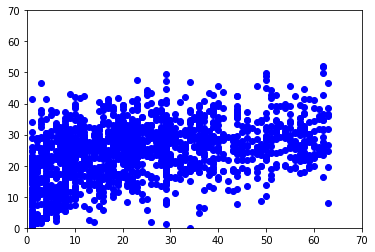

In [195]:
np.random.seed(42)
model_ta = xgb.XGBRegressor(learning_rate= 0.01, 
      gamma = 0.5, 
      min_child_weight = 3,
      nthread = 15,
      max_depth= 30,
      subsample= 0.9,
      eval_metric= 'rmse',
      colsample_bytree= 0.8, 
      n_estimators=500,
      max_leaves=300)

select_ta = SelectFromModel(model_ta, threshold="2*mean")
select_ta.fit(X_train1,y_train1)
X_train_s1_ta = select_ta.transform(X_train1)
X_test_s1_ta = select_ta.transform(X_test1)

print('X_shape:', X_train_s1_ta)

X = X_train_s1_ta
y = y_train1
y= y.reset_index(drop=True)


kf = KFold(n_splits=5)
kf.get_n_splits(X)

print(kf)  

KFold(n_splits=5, random_state=None, shuffle=False)
for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_test, label=y_test)
dtest = xgb.DMatrix(X_test_s1_ta)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Try different parameters! My favorite is random search :)
xgb_pars = {'learning_rate': 0.01, 
    'gamma' : 0.5, 
    'min_child_weight' : 3,
    'nthread' : 15,
    'max_depth' : 30,
    'subsample' : 0.9,
    'eval_metric' : 'rmse',
    'colsample_bytree' : 0.8, 
    'num_boost_round' : 500,
    'n_estimators': 200,
    'max_leaves': 300,
    'objective': 'reg:squarederror'}
model = xgb.train(xgb_pars, dtrain, 500, watchlist, early_stopping_rounds=250,
                  maximize=False, verbose_eval=15)

y_pred_ta = model.predict(dtest)
ta_real = y_test1.reset_index()
ta_real['pred'] = y_pred_ta
linreg_RMSEk_ta = np.sqrt(mse(ta_real['pred'], ta_real['survival_time']))
print(linreg_RMSEk_ta)
#plt.figure(figsize=(15,10))

plt.plot(ta_real['survival_time'],ta_real['pred'],'bo')
plt.axis([0, 70, 0, 70]); plt.show()

(array([127., 129., 137., 217., 385., 462., 255.,  74.,  10.,   5.]),
 array([ 0.98975587,  6.031292  , 11.072828  , 16.114365  , 21.155901  ,
        26.197437  , 31.238972  , 36.28051   , 41.322044  , 46.363583  ,
        51.405117  ], dtype=float32),
 <a list of 10 Patch objects>)

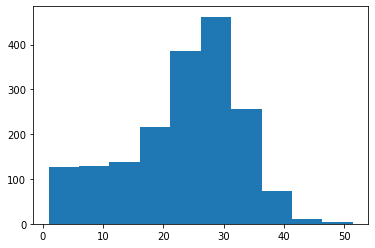

In [112]:
plt.hist(y_pred_ta)

In [92]:
dtest2 = xgb.DMatrix(data[data.columns[1:]].values)
all_pred =model.predict(dtest2)

27.71572041571847


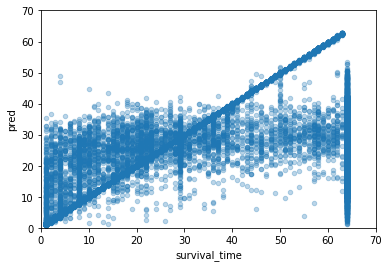

In [115]:
# 모든 데이터
all_real = train_label['survival_time'].reset_index()
all_real['pred'] = all_pred
linreg_RMSEk_all = np.sqrt(mse(all_real['pred'], all_real['survival_time']))
print(linreg_RMSEk_all)
#plt.figure(figsize=(15,10))

all_real.plot(kind='scatter',x = 'survival_time',y='pred',alpha=0.3)
plt.axis([0, 70, 0, 70]); plt.show()

In [96]:
# 64인 데이터
data_64 = data_lbl[data_lbl['survival_time']==64].drop(['pred', 'survival_time', 'amount_spent_y',
       'secession', 'total_spent'],axis=1)

36.76355807857567


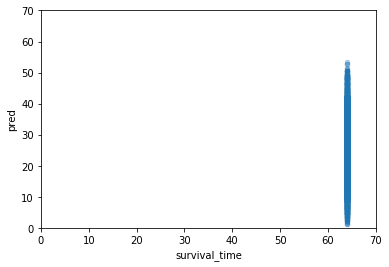

In [100]:
dtest3 = xgb.DMatrix(data_64[data_64.columns[1:]].values)
all_pred2 =model.predict(dtest3)
# 64 데이터
r_real = data_lbl[data_lbl['survival_time']==64]['survival_time'].reset_index()
r_real['pred'] = all_pred2
linreg_RMSEk_r = np.sqrt(mse(r_real['pred'], r_real['survival_time']))
print(linreg_RMSEk_r)
#plt.figure(figsize=(15,10))

r_real.plot(kind='scatter',x='survival_time',y='pred',alpha=0.3)
plt.axis([0, 70, 0, 70]); plt.show()

(array([  95.,  387., 1193., 2679., 4830., 6946., 4603., 1076.,  143.,
          44.]),
 array([ 1.1860079,  6.4119916, 11.637976 , 16.86396  , 22.089943 ,
        27.315928 , 32.541912 , 37.767895 , 42.993877 , 48.219864 ,
        53.445847 ], dtype=float32),
 <a list of 10 Patch objects>)

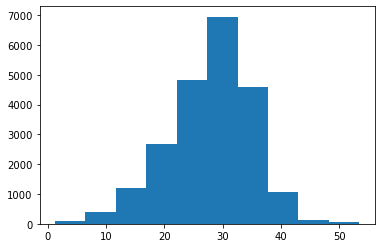

In [103]:
plt.hist(r_real['pred'])

------------------

# test

In [108]:
# 파일 불러오기
test1 = pd.read_csv('./merge_all_flatten_test1.csv')    
test2 = pd.read_csv('./merge_all_flatten_test2.csv')   

In [106]:
import pickle
from sklearn.externals import joblib 
# 객체를 pickled binary file 형태로 저장한다 
file_name = './xgbreg_surv_400f_noselect_63.pkl' 

joblib.dump(model, file_name)

['./xgbreg_surv_400f_noselect_63.pkl']

In [107]:
import pickle
# 다중 분류 모델 불러오기
model_reg = pickle.load(open('./xgbreg_surv_400f_noselect_63.pkl','rb')) # model

In [117]:
pred_64_t1 = OVR.predict(test1[test1.columns[1:]])
pred_64_t2 = OVR.predict(test2[test2.columns[1:]])

In [118]:
test1_predict = test1[['acc_id']]
test1_predict['secession'] = pred_64_t1

test2_predict = test2[['acc_id']]
test2_predict['secession'] = pred_64_t2

C:\ProgramData\Anaconda3\envs\jy3.6\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\envs\jy3.6\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000017ECD2EF438>,
      dtype=object)

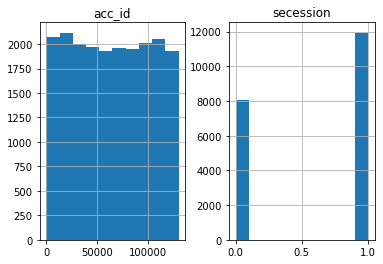

In [120]:
test1_predict.hist()

In [123]:
test1_for_63 = pd.merge(test1_predict[test1_predict['secession']==0][['acc_id']], test1, on ='acc_id', how='left')
test2_for_63 = pd.merge(test2_predict[test2_predict['secession']==0][['acc_id']], test2, on ='acc_id', how='left')

In [124]:
test1_for_63.shape

(8068, 401)

In [125]:
# 이탈자의 생존기간 예측
dtest_t1 = xgb.DMatrix(test1_for_63[test1_for_63.columns[1:]].values)
pred_t1 =model.predict(dtest_t1)

dtest_t2 = xgb.DMatrix(test2_for_63[test2_for_63.columns[1:]].values)
pred_t2 =model.predict(dtest_t2)

In [148]:
# (2)전체 생존기간 예측
dtest_t1 = xgb.DMatrix(test1[test1.columns[1:]].values)
pred_t1 =model.predict(dtest_t1)

dtest_t2 = xgb.DMatrix(test2[test2.columns[1:]].values)
pred_t2 =model.predict(dtest_t2)

(array([ 885.,  676., 1265., 3128., 5017., 5127., 3208.,  640.,   47.,
           7.]),
 array([ 0.85783595,  5.5073137 , 10.156791  , 14.806269  , 19.455746  ,
        24.105225  , 28.754702  , 33.40418   , 38.053658  , 42.703133  ,
        47.35261   ], dtype=float32),
 <a list of 10 Patch objects>)

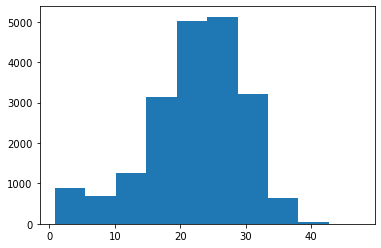

In [149]:
plt.hist(pred_t1)

In [130]:
pred_t1

array([28.105858, 25.852972, 32.27029 , ..., 16.765991, 32.068348,
       22.15191 ], dtype=float32)

In [137]:
test1_for_63['survival_time'] = pred_t1
test2_for_63['survival_time'] = pred_t2

# 이탈분류와 다중분류로 구한 survival time을 merge
test1_predict_s = pd.merge(test1_predict[['acc_id']], test1_for_63[['acc_id','survival_time']], on ='acc_id', how='outer').fillna(64)
test2_predict_s = pd.merge(test2_predict[['acc_id']], test2_for_63[['acc_id','survival_time']], on ='acc_id', how='outer').fillna(64)

In [150]:
##(2) 전체 생존기간 예측
test1_predict_s = test1[['acc_id']]
test2_predict_s = test2[['acc_id']]

test1_predict_s['survival_time'] = pred_t1
test2_predict_s['survival_time'] = pred_t2

C:\ProgramData\Anaconda3\envs\jy3.6\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\ProgramData\Anaconda3\envs\jy3.6\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [154]:
test2_predict_s.head()

,acc_id,survival_time,total_spent
0,1,23.639717,1.103587
1,3,19.261755,9.312283
2,9,9.485052,7.908499
3,14,22.901873,6.859209
4,26,28.743023,9.046825


In [139]:
# 결제량 예측
# 총결제량 모델 불러오기
model_total = pickle.load(open('./xgb_total_63.pkl','rb')) # model

[14:31:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [141]:
# 총결제량 예측
dtest_tt1 = xgb.DMatrix(test1[test1.columns[1:]].values)
pred_tt1 =model_total.predict(dtest_tt1)

dtest_tt2 = xgb.DMatrix(test2[test2.columns[1:]].values)
pred_tt2 =model_total.predict(dtest_tt2)


In [153]:
# 총결제량 가져오기(1,2)
test1_predict_s['total_spent'] = pred_tt1
test2_predict_s['total_spent'] = pred_tt2


C:\ProgramData\Anaconda3\envs\jy3.6\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\envs\jy3.6\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [155]:
test1_predict_s['amount_spent'] = test1_predict_s['total_spent'] / test1_predict_s['survival_time']
test2_predict_s['amount_spent'] = test2_predict_s['total_spent'] / test2_predict_s['survival_time']

# 0 이하의 결제량은 0으로
test1_predict_s['amount_spent'] = np.where(test1_predict_s['amount_spent']<0, 0,test1_predict_s['amount_spent'])

test2_predict_s['amount_spent'] = np.where(test2_predict_s['amount_spent']<0, 0,test2_predict_s['amount_spent'])


# 64이상으로  예측하면 64로 변경
test1_predict_s['survival_time'] = np.where(test1_predict_s['survival_time']>64 , 64,test1_predict_s['survival_time'])

test2_predict_s['survival_time'] = np.where(test2_predict_s['survival_time']>64, 64 ,test2_predict_s['survival_time'])

# 1 미만으로 예측하면 1
test1_predict_s['survival_time'] = np.where(test1_predict_s['survival_time']<1 , 1,test1_predict_s['survival_time'])

test2_predict_s['survival_time'] = np.where(test2_predict_s['survival_time']<1, 1 ,test2_predict_s['survival_time'])

C:\ProgramData\Anaconda3\envs\jy3.6\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\envs\jy3.6\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\envs\jy3.6\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

In [156]:
a = round(test1_predict_s['survival_time'])

In [158]:
# 반올림
test1_predict_s['survival_time'] = round(test1_predict_s['survival_time'])
test2_predict_s['survival_time'] = round(test2_predict_s['survival_time'])

C:\ProgramData\Anaconda3\envs\jy3.6\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\envs\jy3.6\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [159]:
test1_predict_s[['acc_id','survival_time','amount_spent']].to_csv('./0904predict/test1_predict.csv', index=False)
test2_predict_s[['acc_id','survival_time','amount_spent']].to_csv('./0904predict/test2_predict.csv', index=False)

------

-----------

# 종합 모델 만들기

결제량 계획

1. 비과금, 10 미만, 10 이상 20 미만, 20이상으로 분류 (각각 무과금,1,2,3 그룹이라 칭함) (train, valid, test 사용)
    - 전체 유저 대상으로 과금 여부, 10 이상 ,20 이상 여부 모델 각각 만듦  (fit)
    - 만들어진 모델로 유저(train,valid data) 분류 (predict)
    - 세 모델 크로스체크해서 상충되는 예측 결과 정리


2. 1그룹은 전반적으로 상관관계 높은 총결제량으로 예측
    - 1그룹으로 분류된 유저(train,valid data)를 대상으로 일평균결제량 예측 모델 생성 (fit)


3. 2그룹은 전반적으로 상관관계 높은 일평균결제량으로 예측
    - 2그룹으로 분류된 유저(train,valid data)를 대상으로 일평균결제량 예측 모델 생성 (fit)


4. 3그룹은 전반적으로 상관관계 높은 일평균결제량으로 예측
    - 3그룹으로 분류된 유저(train,valid data)를 대상으로 일평균결제량 예측 모델 생성 (fit)


5. test 데이터로 최종 테스트
    - test 데이터 그룹 분류 (predict)
    - test 데이터 각 그룹의 결제량 예측 (predict)

In [196]:
train_label = pd.read_csv('./train_label_add.csv')
train_label = train_label.sort_values('acc_id')

In [223]:
total_g.head()

,acc_id,amount_spent,spent_0,under_10,under_20
22410,2,0.000000,1,0,0
12651,5,0.000000,1,0,0
5494,8,0.020310,0,0,0
6811,17,0.070642,0,0,0
16854,20,0.052137,0,0,0


In [198]:
data.head()

,acc_id,temp_cnt_x,private_shop,level_x,party_exp,pledge_cnt,random_attacker_cnt_x,random_defender_cnt_x,same_pledge_cnt_x,etc_cnt_x,...,random_defender_cnt_4_y,same_pledge_cnt_4_y,temp_cnt_4_y,etc_cnt_4_y,combat_play_time_4,pledge_rank_4,amount_spent_1,amount_spent_2,amount_spent_3,amount_spent_4
0,2,0.000000,84.900753,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
1,5,0.479728,0.000000,173.0,0.695285,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.715313,0.000000,1.384363,0.417618,3.661882,66814.0,0.000000,0.000000,0.000000,0.000000
2,8,3.837822,0.000000,1922.0,0.000000,0.128368,4.270875,0.000000,0.000000,0.225223,...,4.077286,4.774303,21.556504,6.243030,29.782361,22331.0,1.056123,0.000000,0.000000,0.348521
3,17,3.358094,0.000000,687.0,8.823094,0.000000,0.000000,2.366129,12.398273,0.563058,...,1.859815,0.000000,10.778252,2.526941,15.140507,2673.0,0.000000,0.000000,0.000000,0.000000
4,20,0.959456,2.917510,930.0,0.110339,1.540422,0.000000,2.366129,0.000000,21.621413,...,2.360534,3.978586,7.317346,11.672059,18.448062,2500.0,0.000000,0.070408,0.826123,0.000000


In [38]:
del data['minus']
del data['plus']

In [224]:
from sklearn.model_selection import train_test_split
#data = pd.merge(data, train_label, on = 'acc_id')
X_train_final, X_test_final, y_train_all, y_test_all = train_test_split(data_lbl, data_lbl['amount_spent_y'], test_size=0.1, random_state=42)

In [200]:
X_train_final.head()

,acc_id,temp_cnt_x,private_shop,level_x,party_exp,pledge_cnt,random_attacker_cnt_x,random_defender_cnt_x,same_pledge_cnt_x,etc_cnt_x,...,combat_play_time_4,pledge_rank_4,amount_spent_1,amount_spent_2,amount_spent_3,amount_spent_4,survival_time,amount_spent_y,secession,total_spent
20038,65474,0.000000,86.672941,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,64,0.000000,0,0.000000
23937,77991,1.918911,0.000000,552.0,0.000744,0.000000,0.0,1.183064,0.000000,0.337835,...,3.355857,6720.0,0.000000,0.000000,0.000000,0.348521,29,0.000000,1,0.000000
6046,19905,6.236461,0.036670,1158.0,45.065686,0.000000,0.0,7.098387,18.597409,8.108030,...,23.850306,7835.0,2.112246,0.000000,3.696431,0.000000,64,0.094135,0,6.024634
23187,75526,3.358094,0.000000,433.0,0.000000,0.000000,0.0,0.000000,0.000000,4.842296,...,0.331740,15030.0,0.000000,0.000000,0.000000,0.000000,14,0.000000,1,0.000000
25421,82816,8.155372,0.000000,1219.0,112.903695,0.513474,0.0,0.000000,0.000000,1.013504,...,24.058338,12787.0,0.000000,0.528062,0.000000,0.000000,64,0.079206,0,5.069176


In [226]:
# 모델 생성용 데이터
train_data = X_train_final.drop(['survival_time', 'amount_spent_y', 'secession',
       'total_spent'], axis=1)
label = X_train_final[['acc_id','total_spent','amount_spent_y']]

# 분류용 데이터셋 만들기 (무과금, 10미만, 20미만 이진분류 모델)
total_g = label[['acc_id','amount_spent_y']]
total_g['spent_0'] = 0
total_g['under_10'] = 0
#total_g['under_20'] = 0
# 무과금이면 1
total_g['spent_0'] = np.where(total_g['amount_spent_y']==0, 1, 0)
# 10 미만이면 1
total_g['under_10'] = np.where(total_g['amount_spent_y']>=1, 1, 0)
# 20 미만이면 1
#total_g['under_20'] = np.where(total_g['amount_spent_y']<20, 1, 0)

# 최종 테스트용 데이터
test_train = X_test_final.drop(['survival_time', 'amount_spent_y', 'secession',
       'total_spent'], axis=1)
test_label = X_test_final[['acc_id','total_spent','amount_spent_y']]

In [227]:
train_data

,acc_id,temp_cnt_x,private_shop,level_x,party_exp,pledge_cnt,random_attacker_cnt_x,random_defender_cnt_x,same_pledge_cnt_x,etc_cnt_x,...,random_defender_cnt_4_y,same_pledge_cnt_4_y,temp_cnt_4_y,etc_cnt_4_y,combat_play_time_4,pledge_rank_4,amount_spent_1,amount_spent_2,amount_spent_3,amount_spent_4
20038,65474,0.000000,86.672941,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
23937,77991,1.918911,0.000000,552.0,0.000744,0.000000,0.000000,1.183064,0.000000,0.337835,...,0.214594,0.000000,1.384363,0.714905,3.355857,6720.0,0.000000,0.000000,0.000000,0.348521
6046,19905,6.236461,0.036670,1158.0,45.065686,0.000000,0.000000,7.098387,18.597409,8.108030,...,9.156011,3.978586,30.752628,6.016525,23.850306,7835.0,2.112246,0.000000,3.696431,0.000000
23187,75526,3.358094,0.000000,433.0,0.000000,0.000000,0.000000,0.000000,0.000000,4.842296,...,0.000000,0.000000,0.296649,0.014157,0.331740,15030.0,0.000000,0.000000,0.000000,0.000000
25421,82816,8.155372,0.000000,1219.0,112.903695,0.513474,0.000000,0.000000,0.000000,1.013504,...,2.718191,0.000000,14.733574,44.635541,24.058338,12787.0,0.000000,0.528062,0.000000,0.000000
3988,13289,1.439183,0.000000,70.0,22.643316,0.000000,0.000000,5.915322,0.000000,0.000000,...,3.576567,0.000000,2.373193,0.311444,11.113988,12924.0,0.000000,0.000000,0.000000,0.528062
22772,74194,0.959456,0.000000,673.0,0.100135,1.604606,0.000000,0.000000,0.000000,1.351338,...,0.357657,3.182869,5.636334,9.060180,16.420671,50419.0,0.000000,1.096021,5.280616,0.011735
2828,9554,0.000000,85.366114,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
31914,103959,0.479728,0.000000,493.0,0.000000,0.000000,0.000000,28.393548,0.000000,17.567398,...,0.929907,0.000000,0.098883,1.288244,11.115957,7343.0,0.000000,0.000000,0.000000,0.000000
20392,66653,0.479728,0.000000,311.0,0.000000,0.000000,0.000000,1.183064,0.000000,13.513383,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.348521,0.418929,0.348521,0.348521


## 1-1-1) 총결제량 0인 유저 분류

In [228]:
# 이진분류 공통 파라미터
import xgboost as xgb

params =   {
    'learning_rate': 0.01, 
    'gamma' : 0.3, 
    'min_child_weight' : 3,
    'nthread' : 15,
    'max_depth' : 30,
    'subsample' : 0.9,
    'eval_metric' : 'auc',
    'colsample_bytree' : 0.8, 
    'num_boost_round' : 500,
    'n_estimators': 200,
    'max_leaves': 300
}

In [229]:
# valid는 사실상 첫번째 test data
# X_test는 최종 테스트용
from sklearn.model_selection import train_test_split

X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(train_data[train_data.columns[1:]], total_g['spent_0'], test_size=0.3, random_state=42)
X_train_0, X_valid_0, y_train_0, y_valid_0 = train_test_split(X_train_0, y_train_0, test_size=0.25, random_state=42)

X_train_0.shape,  X_test_0.shape, X_valid_0.shape, y_train_0.shape, y_test_0.shape, y_valid_0.shape

((18900, 400), (10800, 400), (6300, 400), (18900,), (10800,), (6300,))

X_train.shape : (18900, 400)
X_train_s1.shape : (18900, 201)
[False  True  True  True  True False  True False False  True  True  True
  True  True  True  True False False  True False False False  True False
 False False False  True False  True  True  True  True  True False False
  True False  True False  True False  True False  True False  True  True
 False  True False False False False False False False False False False
 False False  True False  True False False False False False  True False
  True  True False  True False False  True  True False False  True False
 False  True  True False  True False False  True  True  True  True  True
 False  True False  True False  True False False False  True False False
 False  True  True False  True  True  True  True False False  True  True
 False  True  True  True  True False False  True False False False  True
  True  True False  True  True False  True  True False  True False False
  True  True  True  True  True  True False False  True  True  T

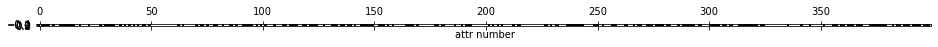

In [230]:
from sklearn.feature_selection import SelectFromModel
select_0 = SelectFromModel(xgb.XGBClassifier(learning_rate= 0.01, 
    gamma = 0.3, 
    min_child_weight = 3,
    nthread = 15,
    max_depth= 30,
    subsample= 0.9,
    eval_metric= 'auc',
    colsample_bytree= 0.8, 
    num_boost_round= 500,
    n_estimators=200,
    max_leaves=300), threshold="0.7*mean")
select_0.fit(X_train_0,y_train_0)

X_train_s1_0 = select_0.transform(X_train_0)
X_test_s1_0 = select_0.transform(X_test_0)
X_valid_s1_0 = select_0.transform(X_valid_0)


print("X_train.shape : {}".format(X_train_0.shape))
print("X_train_s1.shape : {}".format(X_train_s1_0.shape))
mask_0 = select_0.get_support()
print(mask_0)
plt.matshow(mask_0.reshape(1, -1), cmap='gray_r')
plt.xlabel("attr number")
plt.show()

In [231]:
# 모델 학습
VALID = True
if VALID == True:

    tr_data_0 = xgb.DMatrix(X_train_0, y_train_0)
    va_data_0 = xgb.DMatrix(X_valid_0, y_valid_0)

    watchlist = [(tr_data_0, 'train'), (va_data_0, 'valid')]

    model_0 = xgb.train(params, tr_data_0, 500,  watchlist,maximize=False, 
                      early_stopping_rounds = 30, verbose_eval=50)

C:\ProgramData\Anaconda3\envs\jy3.6\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-auc:0.978234	valid-auc:0.871943
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 30 rounds.
[50]	train-auc:0.999391	valid-auc:0.91465
[100]	train-auc:0.999706	valid-auc:0.915862
[150]	train-auc:0.99983	valid-auc:0.916524
[200]	train-auc:0.999861	valid-auc:0.916926
[250]	train-auc:0.999868	valid-auc:0.917216
[300]	train-auc:0.999869	valid-auc:0.917497
[350]	train-auc:0.999868	valid-auc:0.917722
[400]	train-auc:0.999869	valid-auc:0.91784
[450]	train-auc:0.99987	valid-auc:0.917957
[499]	train-auc:0.999873	valid-auc:0.918031


Booster 0.730925925925926
Booster 0.517115320704553
[0.6876423999132039, 0.9829437776373974]
1차 제거될 무과금 유저 비율 :  0.3569334836527621
실제 비과금 유저 수 :  4435
1차 제거될 비과금 유저 수 :  1583
임계값 :  0.6


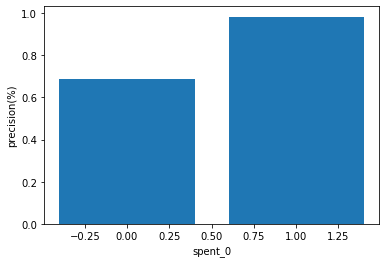

In [232]:
# 민감도 분석
y_pred_spent_0 = np.where(model_0.predict(xgb.DMatrix(X_test_0)) > 0.95, 1, 0)


# 민감도, 재현성 비교를 위해 실제 값과 예측값을 하나의 df로 만듦
pred_spent_0 = y_test_0.reset_index()
pred_spent_0['spent_0_pred'] = y_pred_spent_0


aa = []
for i in range(0,2):
    cc = np.where((pred_spent_0['spent_0']==i) & (pred_spent_0['spent_0_pred']==i), 1, 0).sum() / pred_spent_0[pred_spent_0['spent_0_pred']==i]['spent_0'].count()
    aa.append(cc)

aanp = np.array(aa)
x = np.arange(0,2)
plt.bar(x,aa)
plt.xlabel('spent_0')
plt.ylabel('precision(%)')
print(model_0.__class__.__name__, accuracy_score(y_test_0, y_pred_spent_0))
print(model_0.__class__.__name__, f1_score(y_test_0, y_pred_spent_0))
print(aa)
print('1차 제거될 무과금 유저 비율 : ', pred_spent_0[pred_spent_0['spent_0_pred']==1]['spent_0_pred'].count() / pred_spent_0[pred_spent_0['spent_0']==1]['spent_0'].count())
print('실제 비과금 유저 수 : ',pred_spent_0[pred_spent_0['spent_0']==1]['spent_0'].count())
print('1차 제거될 비과금 유저 수 : ',pred_spent_0[pred_spent_0['spent_0_pred']==1]['spent_0_pred'].count())
print('임계값 : ', 0.6)
# 총결제량이랑 같은 값

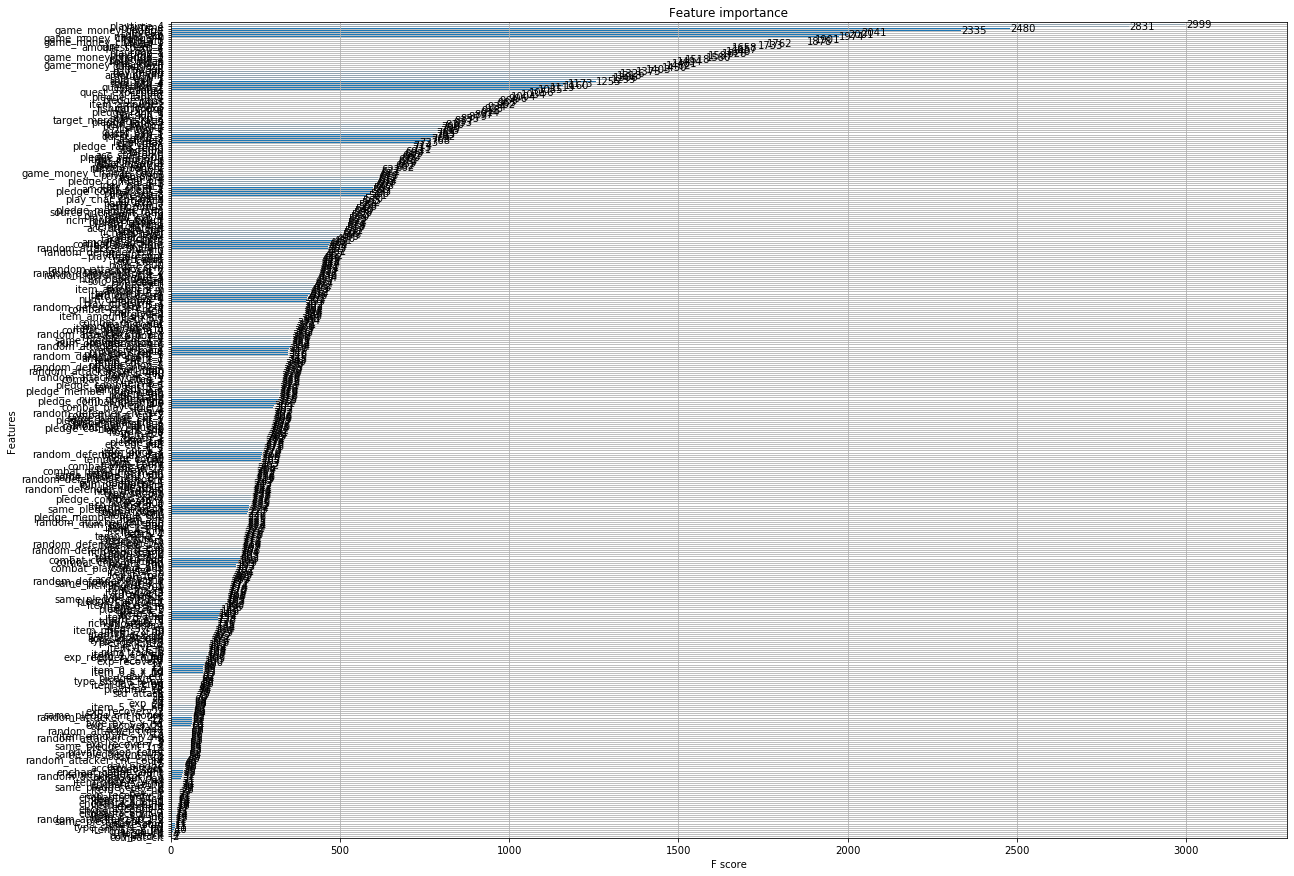

In [213]:
from xgboost import plot_importance
from matplotlib import pyplot as plt
fig, ax = plt.subplots(1,1,figsize=(20,15))
plot_importance(model_0, ax=ax)
plt.show()

## 1-1-2) 일평균결제량 1 이상인 유저 분류

In [233]:
from sklearn.model_selection import train_test_split

X_train_10, X_test_10, y_train_10, y_test_10 = train_test_split(train_data[train_data.columns[1:]], total_g['under_10'], test_size=0.3, random_state=42)
X_train_10, X_valid_10, y_train_10, y_valid_10 = train_test_split(X_train_10, y_train_10, test_size=0.25, random_state=42)

X_train_10.shape, X_test_10.shape,  X_valid_10.shape, y_train_10.shape, y_test_10.shape,  y_valid_10.shape

((18900, 400), (10800, 400), (6300, 400), (18900,), (10800,), (6300,))

X_train.shape : (18900, 400)
X_train_s1.shape : (18900, 244)
[ True False  True  True  True  True False False  True  True  True  True
  True  True False  True False False  True  True False False False  True
 False  True False  True  True  True  True  True False  True  True  True
  True False  True  True  True False False False False False False  True
  True False  True False False  True  True  True False False False  True
  True False  True  True  True  True  True False False False False False
 False False False False  True False False False  True False  True  True
 False  True  True  True  True  True False  True False  True  True False
  True  True False  True  True  True False  True False  True  True  True
 False  True  True  True  True  True  True False  True  True  True  True
  True  True  True  True False False  True  True False False False  True
 False  True  True  True  True  True  True False  True False  True  True
  True  True  True  True  True  True  True False  True  True  T

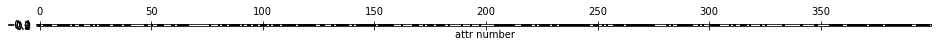

In [234]:
from sklearn.feature_selection import SelectFromModel
select_10 = SelectFromModel(xgb.XGBClassifier(learning_rate= 0.01, 
    gamma = 0.3, 
    min_child_weight = 3,
    nthread = 15,
    max_depth= 30,
    subsample= 0.9,
    eval_metric= 'auc',
    colsample_bytree= 0.8, 
    num_boost_round= 500,
    n_estimators=200,
    max_leaves=300), threshold="0.7*mean")
select_10.fit(X_train_10,y_train_10)

X_train_s1_10 = select_10.transform(X_train_10)
X_test_s1_10 = select_10.transform(X_test_10)
X_valid_s1_10 = select_10.transform(X_valid_10)


print("X_train.shape : {}".format(X_train_10.shape))
print("X_train_s1.shape : {}".format(X_train_s1_10.shape))
mask_10 = select_10.get_support()
print(mask_10)
plt.matshow(mask_10.reshape(1, -1), cmap='gray_r')
plt.xlabel("attr number")
plt.show()

In [235]:
# 모델 학습
VALID = True
if VALID == True:

    tr_data_10 = xgb.DMatrix(X_train_10, y_train_10)
    va_data_10 = xgb.DMatrix(X_valid_10, y_valid_10)

    

    watchlist = [(tr_data_10, 'train'), (va_data_10, 'valid')]

    model_10 = xgb.train(params, tr_data_10, 500,  watchlist,maximize=False, 
                      early_stopping_rounds = 30, verbose_eval=50)

C:\ProgramData\Anaconda3\envs\jy3.6\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-auc:0.813966	valid-auc:0.669089
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 30 rounds.
[50]	train-auc:0.979723	valid-auc:0.794639
[100]	train-auc:0.997711	valid-auc:0.806072
Stopping. Best iteration:
[94]	train-auc:0.997394	valid-auc:0.80841



Booster 0.9885185185185185
Booster 0.06060606060606061
[0.9885142645424231, 1.0]
1차 분류될 일평균결제량 1 이상인 유저 비율 :  0.03125
실제 일평균결제량 1 이상인 유저 수 :  128
1차 분류될 일평균결제량 1 이상인 유저 수 :  4
임계값 :  0.7


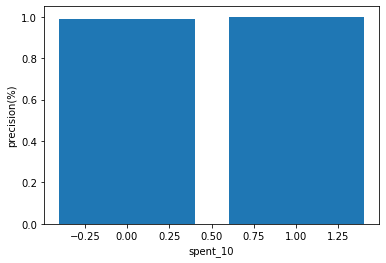

In [240]:
# 민감도 분석
y_pred_under_10 = np.where(model_10.predict(xgb.DMatrix(X_test_10)) > 0.8, 1, 0)

# 민감도, 재현성 비교를 위해 실제 값과 예측값을 하나의 df로 만듦
pred_under_10 = y_test_10.reset_index()
pred_under_10['under_10_pred'] = y_pred_under_10


aa10 = []
for i in range(0,2):
    cc10 = np.where((pred_under_10['under_10']==i) & (pred_under_10['under_10_pred']==i), 1, 0).sum() / pred_under_10[pred_under_10['under_10_pred']==i]['under_10'].count()
    aa10.append(cc10)

aanp10 = np.array(aa10)
x = np.arange(0,2)
plt.bar(x,aa10)
plt.xlabel('spent_10')
plt.ylabel('precision(%)')
print(model.__class__.__name__, accuracy_score(y_test_10, y_pred_under_10))
print(model.__class__.__name__, f1_score(y_test_10, y_pred_under_10))
print(aa10)
print('1차 분류될 일평균결제량 1 이상인 유저 비율 : ', pred_under_10[pred_under_10['under_10_pred']==1]['under_10_pred'].count() / pred_under_10[pred_under_10['under_10']==1]['under_10'].count())
print('실제 일평균결제량 1 이상인 유저 수 : ',pred_under_10[pred_under_10['under_10']==1]['under_10'].count())
print('1차 분류될 일평균결제량 1 이상인 유저 수 : ',pred_under_10[pred_under_10['under_10_pred']==1]['under_10_pred'].count())
print('임계값 : ', 0.7)

Booster 0.8712037037037037
Booster 0.9303141125194128
[0.775, 0.8726503759398496]
1차 분류될 총결제량 10 이하인 유저 비율 :  1.14150842184315
실제 총결제량 10 이하인 유저 수 :  9321
1차 분류될 총결제량 10 이하인 유저 수 :  10640
임계값 :  0.7


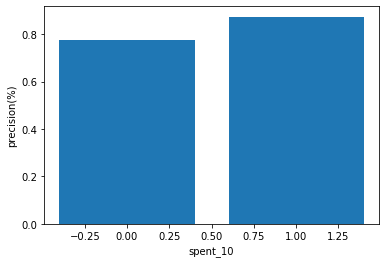

In [221]:
# 민감도 분석
y_pred_under_10 = np.where(model_10.predict(xgb.DMatrix(X_test_10)) > 0.3, 1, 0)

# 민감도, 재현성 비교를 위해 실제 값과 예측값을 하나의 df로 만듦
pred_under_10 = y_test_10.reset_index()
pred_under_10['under_10_pred'] = y_pred_under_10


aa10 = []
for i in range(0,2):
    cc10 = np.where((pred_under_10['under_10']==i) & (pred_under_10['under_10_pred']==i), 1, 0).sum() / pred_under_10[pred_under_10['under_10_pred']==i]['under_10'].count()
    aa10.append(cc10)

aanp10 = np.array(aa10)
x = np.arange(0,2)
plt.bar(x,aa10)
plt.xlabel('spent_10')
plt.ylabel('precision(%)')
print(model.__class__.__name__, accuracy_score(y_test_10, y_pred_under_10))
print(model.__class__.__name__, f1_score(y_test_10, y_pred_under_10))
print(aa10)
print('1차 분류될 일평균결제량 1 이상인 유저 비율 : ', pred_under_10[pred_under_10['under_10_pred']==1]['under_10_pred'].count() / pred_under_10[pred_under_10['under_10']==1]['under_10'].count())
print('실제 일평균결제량 1 이상인 유저 수 : ',pred_under_10[pred_under_10['under_10']==1]['under_10'].count())
print('1차 분류될 일평균결제량 1 이상인 유저 수 : ',pred_under_10[pred_under_10['under_10_pred']==1]['under_10_pred'].count())
print('임계값 : ', 0.7)

## 1-1-3) 총결제량 20 미만인 유저 분류

In [1180]:
X_train_20, X_test_20, y_train_20, y_test_20 = train_test_split(train_data[train_data.columns[1:]], total_g['under_20'], test_size=0.3, random_state=42)
X_train_20, X_valid_20, y_train_20, y_valid_20 = train_test_split(X_train_20, y_train_20, test_size=0.25, random_state=42)

X_train_20.shape, X_test_20.shape,  X_valid_20.shape, y_train_20.shape, y_test_20.shape,  y_valid_20.shape

((18900, 128), (10800, 128), (6300, 128), (18900,), (10800,), (6300,))

[21:50:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
X_train.shape : (18900, 128)
X_train_s1.shape : (18900, 115)
[False False False False False False  True False False False  True  True
  True  True  True  True False False  True  True  True  True  True  True
  True  True  True False False  True  True  True  True  True  True  True
  True False  True  True  True  True False False  True False False  True
  True False False False  True  True  True False  True  True False  True
  True  True False False False False False False False False  True False
 False  True  True False  True False  True False  True False  True  True
 False  True  True  True  True  True False  True  True  True  True  True
 False False  True  True  True  True False  True  True  True  True  True
  True False  True  True False False False False False  True  True False
 False  True  True  True  True  True  True  T

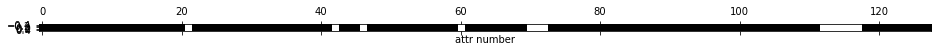

In [1229]:
from sklearn.feature_selection import SelectFromModel
select_20 = SelectFromModel(xgb.XGBRegressor(learning_rate= 0.02, 
    gamma = 0.3, 
    min_child_weight = 3,
    nthread = 15,
    max_depth= 30,
    subsample= 0.9,
    eval_metric= 'auc',
    colsample_bytree= 0.8, 
    num_boost_round= 500,
    n_estimators=200,
    max_leaves=300), threshold="0.6*mean")
select_20.fit(X_train_20,y_train_20)

X_train_s1_20 = select_20.transform(X_train_20)
X_test_s1_20 = select_20.transform(X_test_20)
X_valid_s1_20 = select_20.transform(X_valid_20)


print("X_train.shape : {}".format(X_train_20.shape))
print("X_train_s1.shape : {}".format(X_train_s1_20.shape))
mask_20 = select_20.get_support()
print(mask_g2)
plt.matshow(mask_20.reshape(1, -1), cmap='gray_r')
plt.xlabel("attr number")
plt.show()

In [1230]:
# 모델 학습
VALID = True
if VALID == True:

    tr_data_20 = xgb.DMatrix(X_train_s1_20, y_train_20)
    va_data_20 = xgb.DMatrix(X_valid_s1_20, y_valid_20)

    

    watchlist = [(tr_data_20, 'train'), (va_data_20, 'valid')]

    model_20 = xgb.train(params, tr_data_20, 500,  watchlist,maximize=False, 
                      early_stopping_rounds = 30, verbose_eval=50)

C:\ProgramData\Anaconda3\envs\jy3.6\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-auc:0.904628	valid-auc:0.806142
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 30 rounds.
[50]	train-auc:0.998268	valid-auc:0.839378
Stopping. Best iteration:
[30]	train-auc:0.994465	valid-auc:0.843497



Booster 0.956574074074074
Booster 0.9777798834509878
[0.3076923076923077, 0.9589257503949447]
1차 분류될 총결제량 20 이하인 유저 비율 :  1.040112120626329
실제 총결제량 20 이하인 유저 수 :  10346
1차 분류될 총결제량 20 이하인 유저 수 :  10761
임계값 :  0.68


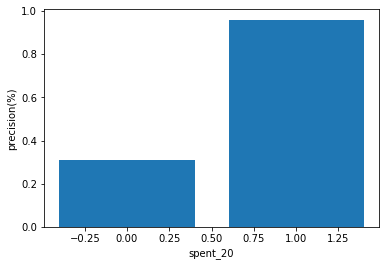

In [1232]:
# 민감도 분석
y_pred_under_20 = np.where(model_20.predict(xgb.DMatrix(X_test_s1_20)) > 0.7, 1, 0)

# 민감도, 재현성 비교를 위해 실제 값과 예측값을 하나의 df로 만듦
pred_under_20 = y_test_20.reset_index()
pred_under_20['under_20_pred'] = y_pred_under_20


aa20 = []
for i in range(0,2):
    cc20 = np.where((pred_under_20['under_20']==i) & (pred_under_20['under_20_pred']==i), 1, 0).sum() / pred_under_20[pred_under_20['under_20_pred']==i]['under_20'].count()
    aa20.append(cc20)

aanp20 = np.array(aa20)
x = np.arange(0,2)
plt.bar(x,aa20)
plt.xlabel('spent_20')
plt.ylabel('precision(%)')
print(model_20.__class__.__name__, accuracy_score(y_test_20, y_pred_under_20))
print(model_20.__class__.__name__, f1_score(y_test_20, y_pred_under_20))
print(aa20)
print('1차 분류될 총결제량 20 이하인 유저 비율 : ', pred_under_20[pred_under_20['under_20_pred']==1]['under_20_pred'].count() / pred_under_20[pred_under_20['under_20']==1]['under_20'].count())
print('실제 총결제량 20 이하인 유저 수 : ',pred_under_20[pred_under_20['under_20']==1]['under_20'].count())
print('1차 분류될 총결제량 20 이하인 유저 수 : ',pred_under_20[pred_under_20['under_20_pred']==1]['under_20_pred'].count())
print('임계값 : ', 0.68)

In [ ]:
Booster 0.9382407407407407
Booster 0.9677699927518725
[0.2638580931263858, 0.9676297226785197]

## 1-2,3) train_data를 각 그룹으로 분류

In [1017]:
all_pred_under_0 = np.where(model_0.predict(xgb.DMatrix(spent_0_df)) > 0.6, 1, 0)
all_pred_under_10 = np.where(model_10.predict(xgb.DMatrix(train_data[train_data.columns[1:]])) > 0.7, 1, 0)
all_pred_under_20 = np.where(model_20.predict(xgb.DMatrix(train_data[train_data.columns[1:]])) > 0.68, 1, 0)

In [1018]:
# 분류를 위한 크로스체크
crosscheck = train_data[['acc_id']]

crosscheck['pred_spent_0'] = 0
crosscheck['pred_under_10'] = 0
crosscheck['pred_under_20'] = 0

crosscheck['pred_spent_0'] = all_pred_under_0
crosscheck['pred_under_10'] = all_pred_under_10
crosscheck['pred_under_20'] = all_pred_under_20



C:\ProgramData\Anaconda3\envs\jy3.6\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\envs\jy3.6\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\ProgramData\Anaconda3\envs\jy3.6\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

In [1019]:
## 정상적의 경우
# 1,1,1 : 무과금 그룹 1
# 0,1,1 : 0 초과 10 미만 그룹 2
# 0,1,1 : 10 이상 20 미만 그룹 3
# 0,0,0 : 20 이상 그룹 4
crosscheck['group_1'] = np.where((crosscheck['pred_spent_0']==1) & (crosscheck['pred_under_10']==1) & (crosscheck['pred_under_20']==1),1,0)

crosscheck['group_2'] = np.where((crosscheck['pred_spent_0']==0) & (crosscheck['pred_under_10']==1) & (crosscheck['pred_under_20']==1),1,0)

crosscheck['group_3'] = np.where((crosscheck['pred_spent_0']==0) & (crosscheck['pred_under_10']==0) & (crosscheck['pred_under_20']==1),1,0)

crosscheck['group_4'] = np.where((crosscheck['pred_spent_0']==0) & (crosscheck['pred_under_10']==0) & (crosscheck['pred_under_20']==0),1,0)

## 3개의 예측 결과가 상충하는 경우(모든 판단은 위에서 한 crosscheck 시뮬레이션을 바탕으로 함: crosscheck_10 찾으세요)
# 1,0,1 : 무과금, 10 미만, 20 이상으로 예측한 경우(x<10, x>=20) --> 무과금으로 판단할 것임
# 1,1,0 : 무과금, 10 이상, 20 미만으로 예측한 경우(x=0, x>=10) --> 무과금으로 판단할 것임
# 1,0,0 : 무과금, 10 이상, 20 이상으로 예측한 경우(x=0, x>=20) --> 무과금으로 판단할 것임
# 0,1,0 : 과금, 10 미만, 20 이상으로 예측한 경우(x<10,x>20) --> 0초과 10 미만인 그룹으로 판단할 것임

crosscheck['group_1'] = np.where((crosscheck['pred_spent_0']==1) & (crosscheck['pred_under_10']==0) & (crosscheck['pred_under_20']==1),1, crosscheck['group_1'])

crosscheck['group_1'] = np.where((crosscheck['pred_spent_0']==1) & (crosscheck['pred_under_10']==1) & (crosscheck['pred_under_20']==0),1, crosscheck['group_1'])

crosscheck['group_1'] = np.where((crosscheck['pred_spent_0']==1) & (crosscheck['pred_under_10']==0) & (crosscheck['pred_under_20']==0),1, crosscheck['group_1'])

crosscheck['group_2'] = np.where((crosscheck['pred_spent_0']==0) & (crosscheck['pred_under_10']==1) & (crosscheck['pred_under_20']==0),1, crosscheck['group_2'])


C:\ProgramData\Anaconda3\envs\jy3.6\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\envs\jy3.6\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\envs\jy3.6\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

In [1020]:
# 그룹별로 나눔
group_1 = crosscheck[crosscheck['group_1']==1][['acc_id']]
group_2 = crosscheck[crosscheck['group_2']==1][['acc_id']]
group_3 = crosscheck[crosscheck['group_3']==1][['acc_id']]
group_4 = crosscheck[crosscheck['group_4']==1][['acc_id']]

In [1021]:
train_data.shape

(36000, 129)

In [1022]:
group_2_data = pd.merge(group_2, train_data, on = 'acc_id', how='inner')
group_3_data = pd.merge(group_3, train_data, on = 'acc_id', how='inner')
group_4_data = pd.merge(group_4, train_data, on = 'acc_id', how='inner')

## 2-1) 2번 그룹 총결제량 예측 모델

In [1023]:
group_2_label = pd.merge(group_2[['acc_id']], total_g[['acc_id','total_spent']], on = 'acc_id', how='inner')

(array([129.,  94.,  90.,  63.,  70.,  76.,  59.,  41.,  42.,  32.,  26.,
         23.,  26.,  21.,  25.,  17.,  15.,   8.,  10.,  14.,  11.,   9.,
         16.,   8.,   3.,   6.,   2.,   1.,   2.,   5.,   0.,   1.,   2.,
          1.,   0.,   0.,   1.,   0.,   2.]),
 array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
        27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
        44, 45, 46, 47, 48, 49]),
 <a list of 39 Patch objects>)

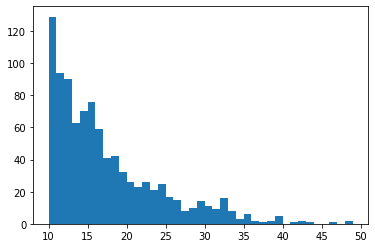

In [1024]:
plt.hist(group_2_label['total_spent'], range(10,50))

In [61]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(group_2_data[group_2_data.columns[1:]],  group_2_label['total_spent'], test_size=0.3, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

NameError: name 'group_2_data' is not defined

[03:08:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
X_train.shape : (13176, 128)
X_train_s1.shape : (13176, 78)
[False False False False False False  True False False False  True  True
  True  True  True  True False False  True  True  True  True  True  True
  True  True  True False False  True  True  True  True  True  True  True
  True False  True  True  True  True False False  True False False  True
  True False False False  True  True  True False  True  True False  True
  True  True False False False False False False False False  True False
 False  True  True False  True False  True False  True False  True  True
 False  True  True  True  True  True False  True  True  True  True  True
 False False  True  True  True  True False  True  True  True  True  True
  True False  True  True False False False False False  True  True False
 False  True  True  True  True  True  True  Tr

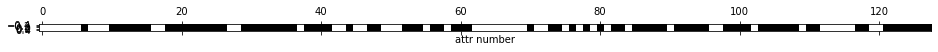

In [943]:
from sklearn.feature_selection import SelectFromModel
select_g2 = SelectFromModel(xgb.XGBRegressor(max_depth=30, n_estimators=200), threshold="0.7*mean")
select_g2.fit(X_train,y_train)

X_train_s1 = select_g2.transform(X_train)
X_test_s1 = select_g2.transform(X_test)

print("X_train.shape : {}".format(X_train.shape))
print("X_train_s1.shape : {}".format(X_train_s1.shape))
mask_g2 = select_g2.get_support()
print(mask_g2)
plt.matshow(mask_g2.reshape(1, -1), cmap='gray_r')
plt.xlabel("attr number")
plt.show()

In [ ]:
# 모델 학습
xgb_g2=xgb.XGBRegressor(max_depth=30, n_estimators=200)
xgb_g2.fit(X_train_s1,y_train)
y_pred_g2 = xgb_g2.predict(X_test_s1)

4.672481741684217

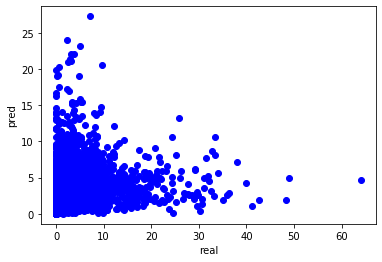

In [726]:
g2_real = y_test.reset_index()
g2_real['total_spent_pred'] = y_pred_g2

plt.plot(g2_real['total_spent'],g2_real['total_spent_pred'],'bo')
plt.xlabel('real')
plt.ylabel('pred')

from sklearn.metrics import mean_squared_error as mse
linreg_RMSEk_g2 = np.sqrt(mse(g2_real['total_spent_pred'], g2_real['total_spent']))
linreg_RMSEk_g2
# 4.8707689056100305 --> 1.5 mean (feature = 15)
# 4.7325415334831265 --> mean, (feature = 42)
## 4.672481741684217 --> 0.7 mean, (feature = 78)
# 4.705162118063246 --> 0.6 mean, (feature = 85)
# 4.685654317081156 --> 0.5 mean, (feature = 98)
#  --> all 

4.4741688028418345

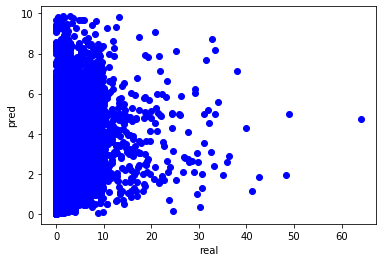

In [755]:
# 총결제량 10 이상이면 중간값은 5로, 음수 값은 0으로 바꿈
g2_real['total_spent_pred'] = np.where(g2_real['total_spent_pred']>=10, 5, g2_real['total_spent_pred'])
g2_real['total_spent_pred'] = np.where(g2_real['total_spent_pred']<0, 0, g2_real['total_spent_pred'])
plt.plot(g2_real['total_spent'],g2_real['total_spent_pred'],'bo')
plt.xlabel('real')
plt.ylabel('pred')

linreg_RMSEk_g2 = np.sqrt(mse(g2_real['total_spent_pred'], g2_real['total_spent']))
linreg_RMSEk_g2
#4.4741688028418345

In [1000]:
columns_g2 = []
for i in range(len(mask_g2)):
    if mask_g2[i] == True:
        columns_g2.append(i+1)
cols_g2 = data.columns[[columns_g2]]
cols_g2 = list(cols_g2)

g2_select = group_2_data[cols_g2]

In [1001]:
g2_select.columns

Index(['random_attacker_cnt', 'num_opponent', 'playtime', 'npc_kill',
       'solo_exp', 'quest_exp', 'rich_monster', 'exp_recovery', 'fishing',
       'game_money_change', 'enchant_count', 'forgive', 'pledge_cnt_count',
       'random_attacker_cnt_count', 'random_defender_cnt_count',
       'temp_cnt_count', 'num_opponent_count', 'playtime_count',
       'npc_kill_count', 'solo_exp_count', 'party_exp_count',
       'quest_exp_count', 'rich_monster_count', 'death_count',
       'exp_recovery_count', 'fishing_count', 'private_shop_count',
       'game_money_change_count', '1', '4', '5', '9', '10', '11', '13', '14',
       '16', '17', '18', '27', 'combat_clt', 'playtime_clt', 'day_pledge',
       'day_defend', 'day_same', 'std_pledge', 'std_attack', 'std_temp',
       'std_same', 'std_etc', 'acc_std_pledge', 'acc_std_attack',
       'acc_std_temp', 'acc_std_same', 'acc_std_etc', 'deff_level',
       'level_max', 'char_max', 'day_sum', 'C_0', 'C_1', 'C_3', 'C_4', 'C_5',
       'C_6', 'C_7

In [1025]:
# 모델 학습
columns_g2 = []
for i in range(len(mask_g2)):
    if mask_g2[i] == True:
        columns_g2.append(i+1)
cols_g2 = data.columns[[columns_g2]]
cols_g2 = list(cols_g2)

g2_select = group_2_data[cols_g2]

X_train, X_test, y_train, y_test = train_test_split(g2_select,  group_2_label['total_spent'], test_size=0.3, random_state=42)

xgb_g2=xgb.XGBRegressor(max_depth=30, n_estimators=200)
xgb_g2.fit(X_train,y_train)

[03:36:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=30, min_child_weight=1, missing=None, n_estimators=200,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

## 3. 3번 그룹 일평균결제량으로 예측

In [880]:
total_g.columns

Index(['acc_id', 'total_spent', 'spent_0', 'under_10', 'under_20'], dtype='object')

In [881]:
group_3_label = pd.merge(group_3[['acc_id']], label[['acc_id','amount_spent_y','total_spent']], on = 'acc_id', how='inner')

(array([ 663.,  444., 1173.,  971.,  322.,   81.,   48.,   32.,   11.,
           5.]),
 array([ 0.        ,  4.63289387,  9.26578775, 13.89868162, 18.5315755 ,
        23.16446937, 27.79736325, 32.43025712, 37.063151  , 41.69604487,
        46.32893875]),
 <a list of 10 Patch objects>)

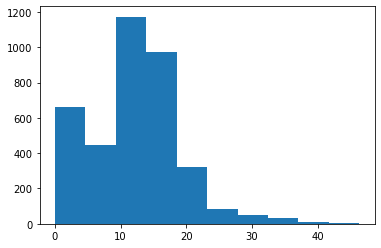

In [882]:
plt.hist(group_3_label['total_spent'])

In [883]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(group_3_data[group_3_data.columns[1:]],  group_3_label['amount_spent_y'], test_size=0.3, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2625, 128), (1125, 128), (2625,), (1125,))

[03:29:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
X_train.shape : (2625, 77)
X_train_s1.shape : (2625, 29)
[False False False False False False False  True  True False False False
 False False  True False False False False False  True  True  True False
  True False False  True False False False False False False  True False
 False False  True False False False False  True  True  True False False
 False  True  True  True False False  True  True  True False False False
 False False False False  True  True  True  True False  True  True False
 False  True  True  True  True]


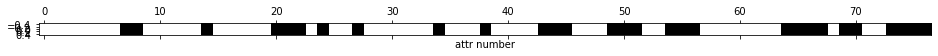

In [975]:
from sklearn.feature_selection import SelectFromModel
select_g3 = SelectFromModel(xgb.XGBRegressor(max_depth=30, n_estimators=200), threshold="mean")
select_g3.fit(X_train,y_train)

X_train_s1 = select_g3.transform(X_train)
X_test_s1 = select_g3.transform(X_test)

print("X_train.shape : {}".format(X_train.shape))
print("X_train_s1.shape : {}".format(X_train_s1.shape))
mask_g3 = select_g3.get_support()
print(mask_g3)
plt.matshow(mask_g3.reshape(1, -1), cmap='gray_r')
plt.xlabel("attr number")
plt.show()

In [772]:
# 모델 학습
xgb_g3=xgb.XGBRegressor(max_depth=30, n_estimators=200)
xgb_g3.fit(X_train_s1,y_train)
y_pred_g3 = xgb_g3.predict(X_test_s1)

[01:57:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\envs\jy3.6\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


1.4572649396893824

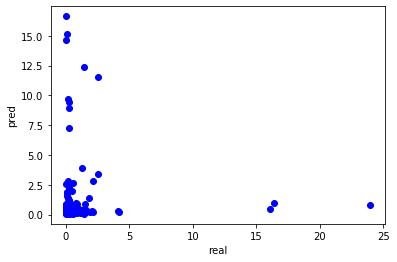

In [773]:
g3_real = y_test.reset_index()
g3_real['amount_spent_pred'] = y_pred_g3
g3_real['amount_spent_pred'] = np.where(g3_real['amount_spent_pred']<0, 0, g3_real['amount_spent_pred'])

plt.plot(g3_real['amount_spent_y'],g3_real['amount_spent_pred'],'bo')
plt.xlabel('real')
plt.ylabel('pred')

from sklearn.metrics import mean_squared_error as mse
linreg_RMSEk_g3 = np.sqrt(mse(g3_real['amount_spent_pred'], g3_real['amount_spent_y']))
linreg_RMSEk_g3

# 1.4572649396893824 --> mean 1.몇 (feature = 10)
# 1.4180457383323843 --> mean (feature = 11)
# 1.662409496963163 --> mean 0.7 (feature = 15)
# 1.6789783979681743 --> mean 0.5 (feature = 17)
# 1.65217939567305 --> mean 0.3 (feature = 20)
# 1.6440569358618562 --> mean 0.1 (feature = 35)
# 1.64962723655327 --> mean 0.08 (feature = 38)

In [1004]:
# 모델 학습
columns_g3 = []
for i in range(len(mask_g3)):
    if mask_g3[i] == True:
        columns_g3.append(i+1)
cols_g3 = data.columns[[columns_g3]]
cols_g3 = list(cols_g3)

g3_select = group_3_data[cols_g3]

X_train, X_test, y_train, y_test = train_test_split(g3_select,  group_3_label['total_spent'], test_size=0.3, random_state=42)

xgb_g3=xgb.XGBRegressor(max_depth=30, n_estimators=200)
xgb_g3.fit(X_train,y_train)

[03:35:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=30, min_child_weight=1, missing=None, n_estimators=200,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

## 4. 4번 그룹 일평균결제량으로 예측

In [885]:
group_4_label = pd.merge(group_4[['acc_id']], label[['acc_id','amount_spent_y','total_spent']], on = 'acc_id', how='inner')

(array([352., 328., 718., 265.,  38.,   4.,   1.,   0.,   0.,   1.]),
 array([ 0.        ,  9.75154877, 19.50309754, 29.2546463 , 39.00619507,
        48.75774384, 58.50929261, 68.26084138, 78.01239014, 87.76393891,
        97.51548768]),
 <a list of 10 Patch objects>)

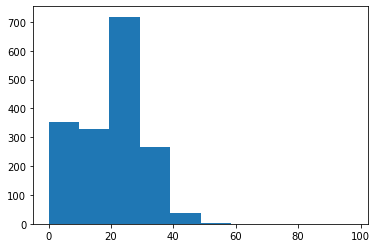

In [886]:
plt.hist(group_4_label['total_spent'])

In [887]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(group_4_data[group_4_data.columns[1:]],  group_4_label['amount_spent_y'], test_size=0.3, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1194, 128), (513, 128), (1194,), (513,))

In [ ]:
from sklearn.feature_selection import SelectFromModel
select_g4 = SelectFromModel(xgb.XGBRegressor(max_depth=30, n_estimators=200), threshold="0.9*mean")
select_g4.fit(X_train,y_train)

X_train_s1 = select_g4.transform(X_train)
X_test_s1 = select_g4.transform(X_test)

print("X_train.shape : {}".format(X_train.shape))
print("X_train_s1.shape : {}".format(X_train_s1.shape))
mask_g4 = select_g4.get_support()
print(mask_g4)
plt.matshow(mask_g4.reshape(1, -1), cmap='gray_r')
plt.xlabel("attr number")
plt.show()

In [820]:
# 모델 학습
xgb_g4=xgb.XGBRegressor(max_depth=30, n_estimators=200)
xgb_g4.fit(X_train_s1,y_train)
y_pred_g4 = xgb_g4.predict(X_test_s1)

[02:20:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\envs\jy3.6\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


1.2028377436965634

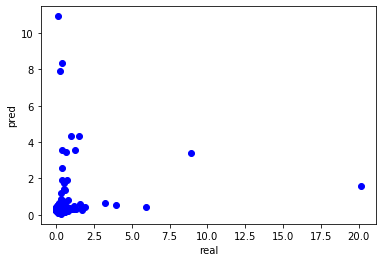

In [821]:
g4_real = y_test.reset_index()
g4_real['amount_spent_pred'] = y_pred_g4
g4_real['amount_spent_pred'] = np.where(g4_real['amount_spent_pred']<0, 0, g4_real['amount_spent_pred'])

plt.plot(g4_real['amount_spent_y'],g4_real['amount_spent_pred'],'bo')
plt.xlabel('real')
plt.ylabel('pred')

from sklearn.metrics import mean_squared_error as mse
linreg_RMSEk_g4 = np.sqrt(mse(g4_real['amount_spent_pred'], g4_real['amount_spent_y']))
linreg_RMSEk_g4

# 1.2062753306239076 --> mean 1.2 (feature = 8)
# 1.2062753306239076 --> mean (feature = 8)
##1.2028377436965634 --> mean 0.9 (feature = 9)
# 1.207852291854915 --> mean 0.75 (feature = 10)
# 1.208650639535378 --> mean 0.11 (feature = 11)
# 1.2194610511554107 --> mean 0.1 (feature = 22)
# 1.2168023152574272 --> mean 0.08 (feature = 29)
# 1.2117882971419436 --> eman 0.05 (feature = 40)
# 1.2128912210144822 --> all 

In [1005]:
# 모델 학습
columns_g4 = []
for i in range(len(mask_g4)):
    if mask_g4[i] == True:
        columns_g4.append(i+1)
cols_g4 = data.columns[[columns_g4]]
cols_g4 = list(cols_g4)

g4_select = group_4_data[cols_g4]

X_train, X_test, y_train, y_test = train_test_split(g4_select,  group_4_label['total_spent'], test_size=0.3, random_state=42)

xgb_g4=xgb.XGBRegressor(max_depth=30, n_estimators=200)
xgb_g4.fit(X_train,y_train)

[03:35:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=30, min_child_weight=1, missing=None, n_estimators=200,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

## 5. 최종 테스트 

In [1026]:
test_train.shape

(4000, 129)

In [1027]:
spent_0_df_test = test_train[spent_0_cols]

# 선별한 컬럼의 값의 유무를 기재 
for col in spent_0_cols:
    spent_0_df_test[str(col) + '_count'] = np.where(spent_0_df_test[col]==0, 0, 1)
    
# 기존의 컬럼 제거    
spent_0_df_test = spent_0_df_test.drop(spent_0_cols, axis=1)

# acc_id 합치기
spent_0_df_acc_test = pd.concat([test_train[['acc_id']],spent_0_df_test], axis=1)

C:\ProgramData\Anaconda3\envs\jy3.6\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [1028]:
all_pred_under_0 = np.where(model_0.predict(xgb.DMatrix(spent_0_df_test)) > 0.6, 1, 0)
all_pred_under_10 = np.where(model_10.predict(xgb.DMatrix(test_train[test_train.columns[1:]])) > 0.7, 1, 0)
all_pred_under_20 = np.where(model_20.predict(xgb.DMatrix(test_train[test_train.columns[1:]])) > 0.72, 1, 0)

In [1160]:
crosscheck_label = pd.merge(crosscheck, train_label[['acc_id','total_spent']], on ='acc_id', how='inner')

,acc_id,pred_spent_0,pred_under_10,pred_under_20,group_1,group_2,group_3,group_4
32823,106945,0,1,1,0,1,0,0
16298,53353,0,0,0,0,0,0,1
28505,92778,0,1,1,0,1,0,0
6689,22031,0,1,1,0,1,0,0
26893,87505,1,1,1,1,0,0,0
36572,119288,1,1,1,1,0,0,0
12335,40465,0,1,1,0,1,0,0
29591,96352,0,0,0,0,0,0,1
18948,61860,1,1,1,1,0,0,0
31067,101220,0,1,1,0,1,0,0


In [1030]:
# 분류를 위한 크로스체크
crosscheck = test_train[['acc_id']]

crosscheck['pred_spent_0'] = 0
crosscheck['pred_under_10'] = 0
crosscheck['pred_under_20'] = 0

crosscheck['pred_spent_0'] = all_pred_under_0
crosscheck['pred_under_10'] = all_pred_under_10
crosscheck['pred_under_20'] = all_pred_under_20

## 정상적의 경우
# 1,1,1 : 무과금 그룹 1
# 0,1,1 : 0 초과 10 미만 그룹 2
# 0,1,1 : 10 이상 20 미만 그룹 3
# 0,0,0 : 20 이상 그룹 4
crosscheck['group_1'] = np.where((crosscheck['pred_spent_0']==1) & (crosscheck['pred_under_10']==1) & (crosscheck['pred_under_20']==1),1,0)

crosscheck['group_2'] = np.where((crosscheck['pred_spent_0']==0) & (crosscheck['pred_under_10']==1) & (crosscheck['pred_under_20']==1),1,0)

crosscheck['group_3'] = np.where((crosscheck['pred_spent_0']==0) & (crosscheck['pred_under_10']==0) & (crosscheck['pred_under_20']==1),1,0)

crosscheck['group_4'] = np.where((crosscheck['pred_spent_0']==0) & (crosscheck['pred_under_10']==0) & (crosscheck['pred_under_20']==0),1,0)

## 3개의 예측 결과가 상충하는 경우(모든 판단은 위에서 한 crosscheck 시뮬레이션을 바탕으로 함: crosscheck_10 찾으세요)
# 1,0,1 : 무과금, 10 미만, 20 이상으로 예측한 경우(x<10, x>=20) --> 무과금으로 판단할 것임
# 1,1,0 : 무과금, 10 이상, 20 미만으로 예측한 경우(x=0, x>=10) --> 무과금으로 판단할 것임
# 1,0,0 : 무과금, 10 이상, 20 이상으로 예측한 경우(x=0, x>=20) --> 무과금으로 판단할 것임
# 0,1,0 : 과금, 10 미만, 20 이상으로 예측한 경우(x<10,x>20) --> 0초과 10 미만인 그룹으로 판단할 것임

crosscheck['group_1'] = np.where((crosscheck['pred_spent_0']==1) & (crosscheck['pred_under_10']==0) & (crosscheck['pred_under_20']==1),1, crosscheck['group_1'])

crosscheck['group_1'] = np.where((crosscheck['pred_spent_0']==1) & (crosscheck['pred_under_10']==1) & (crosscheck['pred_under_20']==0),1, crosscheck['group_1'])

crosscheck['group_1'] = np.where((crosscheck['pred_spent_0']==1) & (crosscheck['pred_under_10']==0) & (crosscheck['pred_under_20']==0),1, crosscheck['group_1'])

crosscheck['group_2'] = np.where((crosscheck['pred_spent_0']==0) & (crosscheck['pred_under_10']==1) & (crosscheck['pred_under_20']==0),1, crosscheck['group_2'])

C:\ProgramData\Anaconda3\envs\jy3.6\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\envs\jy3.6\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\ProgramData\Anaconda3\envs\jy3.6\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

In [1031]:
# 그룹별로 나눔
group_1 = crosscheck[crosscheck['group_1']==1][['acc_id']]
group_2 = crosscheck[crosscheck['group_2']==1][['acc_id']]
group_3 = crosscheck[crosscheck['group_3']==1][['acc_id']]
group_4 = crosscheck[crosscheck['group_4']==1][['acc_id']]

group_2_data = pd.merge(group_2, test_train, on = 'acc_id', how='inner')
group_3_data = pd.merge(group_3, test_train, on = 'acc_id', how='inner')
group_4_data = pd.merge(group_4, test_train, on = 'acc_id', how='inner')

In [1032]:
group_3_data.head()

,acc_id,class,temp_cnt,private_shop,level,party_exp,pledge_cnt,random_attacker_cnt,random_defender_cnt,same_pledge_cnt,...,play_char_cnt,combat_char_cnt,pledge_combat_cnt,p_random_attacker_cnt,p_random_defender_cnt,p_same_pledge_cnt,p_temp_cnt,p_etc_cnt,combat_play_time,pledge_rank
0,128409,195,2.398639,0.0,862,2.643727,0.513474,0.000000,0.000000,0.000000,...,180.951847,92.280390,59.267700,57.161061,42.060427,58.087356,103.135019,197.858750,254.974809,242668
1,49854,13,0.000000,0.0,28,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
2,74846,28,2.878367,0.0,476,0.192016,14.248902,0.000000,5.915322,12.398273,...,25.442970,15.987568,9.015276,7.810828,11.230420,38.990143,17.205650,10.291798,27.661378,17654
3,73873,84,1.918911,0.0,476,0.001583,0.000000,3.131975,3.549193,0.000000,...,2.129270,0.613518,0.000000,0.355038,0.286125,0.000000,0.791064,0.276052,1.986155,144116
4,102860,180,23.506660,0.0,1795,0.133361,46.533576,0.000000,14.196774,0.000000,...,29.629331,11.801207,5.997435,1.291046,4.291880,0.795717,23.731931,12.372808,33.785945,21824


In [1033]:
type(mask_g2)

numpy.ndarray

In [1034]:
# 추출된 특징으로 데이터 변경

columns_g2 = []
for i in range(len(mask_g2)):
    if mask_g2[i] == True:
        columns_g2.append(i+1)
cols_g2 = test_train.columns[[columns_g2]]
cols_g2 = list(cols_g2)

g2_select = group_2_data[cols_g2]


columns_g3 = []
for i in range(len(list(mask_g3))):
    if mask_g3[i] == True:
        columns_g3.append(i+1)
cols_g3 = test_train.columns[[columns_g3]]
cols_g3 = list(cols_g3)

g3_select = group_3_data[cols_g3]

columns_g4 = []
for i in range(len(list(mask_g4))):
    if mask_g4[i] == True:
        columns_g4.append(i+1)
cols_g4 = test_train.columns[[columns_g4]]
cols_g4 = list(cols_g4)

g4_select = group_4_data[cols_g4]

In [1039]:
group_4_data.columns

Index(['acc_id', 'class', 'temp_cnt', 'private_shop', 'level', 'party_exp',
       'pledge_cnt', 'random_attacker_cnt', 'random_defender_cnt',
       'same_pledge_cnt',
       ...
       'play_char_cnt', 'combat_char_cnt', 'pledge_combat_cnt',
       'p_random_attacker_cnt', 'p_random_defender_cnt', 'p_same_pledge_cnt',
       'p_temp_cnt', 'p_etc_cnt', 'combat_play_time', 'pledge_rank'],
      dtype='object', length=129)

In [1036]:
# 예측
y_pred_g2 = xgb_g2.predict(g2_select) # 총결제량
y_pred_g3 = xgb_g3.predict(g3_select) # 일평균결제량
y_pred_g4 = xgb_g4.predict(g4_select) # 일평균결제량

In [1051]:
testing = pd.read_csv('./train_label.csv')

g2_label = group_2_data[['acc_id']]
g2_label['total_spent']= y_pred_g2
g3_label = group_3_data[['acc_id']]
g3_label['amount_spent']= y_pred_g3

g4_label = group_4_data[['acc_id']]
g4_label['amount_spent']= y_pred_g4



C:\ProgramData\Anaconda3\envs\jy3.6\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\envs\jy3.6\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\envs\jy3.6\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

In [1052]:
g2_label = pd.merge(g2_label, testing[['acc_id','survival_time']], on ='acc_id', how='inner')
g2_label.head()

,acc_id,total_spent,survival_time
0,106945,7.958188,64
1,92778,4.378324,64
2,22031,0.492082,64
3,40465,2.032079,1
4,101220,2.798290,64


In [1053]:
g2_label['amount_spent'] = g2_label['total_spent'] / g2_label['survival_time']

In [1055]:
g2_label = g2_label.drop(['survival_time', 'total_spent'],axis=1)

In [1071]:
group_1['amount_spent']=0

In [1118]:
#spent = pd.concat([g2_label,g3_label])
spent2 = pd.concat([g2_label])
spent3 = pd.concat([spent2,group_1])

In [1119]:
spent4 = pd.merge(spent3, testing, on ='acc_id', how='inner')

In [1120]:
spent4.shape

(3277, 4)

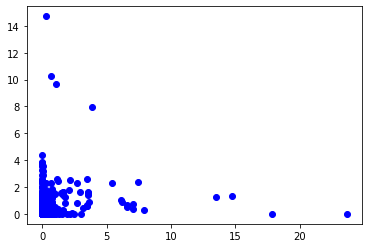

In [1121]:
plt.plot(spent4['amount_spent_y'], spent4['amount_spent_x'],'bo')

In [1122]:
linreg_RMSE_test = np.sqrt(mse(spent4['amount_spent_x'],spent4['amount_spent_y']))


In [1123]:
linreg_RMSE_test

0.8301499792437692

In [1091]:
spent4.shape

(1975, 4)

In [1084]:
spent4[spent4['amount_spent_x']>10]['acc_id']

,acc_id,amount_spent_x,survival_time,amount_spent_y
858,8524,14.720838,1,0.324829
1098,29283,10.247510,1,0.689032
2025,128409,12.339014,64,0.295037
2026,49854,10.962234,1,0.328110
2027,74846,10.849285,58,0.231777
2028,73873,11.871559,64,0.202543
2029,102860,14.688308,64,0.013846
2030,100184,12.546060,21,0.034681
2031,43448,12.004916,64,0.312099
2032,87548,14.968120,64,0.064736


In [1156]:
g2ex.head()

,acc_id,amount_spent,survival_time,total_spent
0,106945,0.124347,64,1.478335
1,92778,0.068411,64,3.683237
2,22031,0.007689,64,0.000000
3,40465,2.032079,1,0.000000
4,101220,0.043723,64,0.936559


5.956866001525858


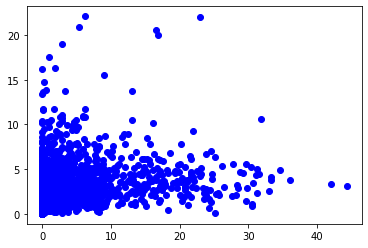

In [1157]:
g2ex = pd.merge(g2_label, train_label[['acc_id','survival_time','total_spent']], on ='acc_id', how='inner')
g2ex['total_pred'] = g2ex['amount_spent'] * g2ex['survival_time']
plt.plot(g2ex['total_spent'],g2ex['total_pred'],'bo')
linreg_RMSE2ex = np.sqrt(mse(g2ex['total_pred'], g2ex['total_spent']))
print(linreg_RMSE2ex)

(array([1.552e+03, 2.290e+02, 7.900e+01, 7.000e+01, 4.200e+01, 2.700e+01,
        1.400e+01, 9.000e+00, 1.000e+00, 2.000e+00]),
 array([ 0.        ,  4.43017409,  8.86034818, 13.29052227, 17.72069636,
        22.15087044, 26.58104453, 31.01121862, 35.44139271, 39.8715668 ,
        44.30174089]),
 <a list of 10 Patch objects>)

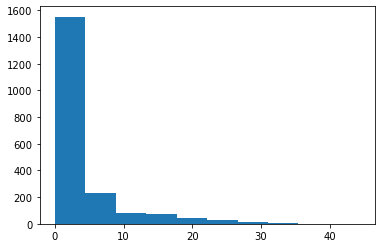

In [1158]:
plt.hist(g2ex['total_spent'])

8.32459440044385


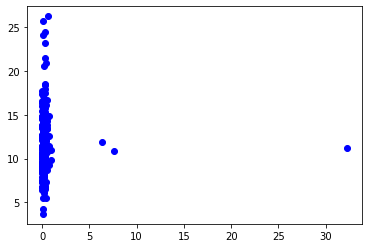

In [1159]:
# 뭐지.. amount_spent를 예측했는데 total spent와 많이 비슷합니다.
g3ex =pd.merge(g3_label,train_label[['acc_id','amount_spent','total_spent']], on = 'acc_id',how='inner')

plt.plot(g3ex['amount_spent_y'],g3ex['amount_spent_x'],'bo')
linreg_RMSE3ex = np.sqrt(mse(g3ex['amount_spent_x'], g3ex['total_spent']))
print(linreg_RMSE3ex)

8.32459440044385


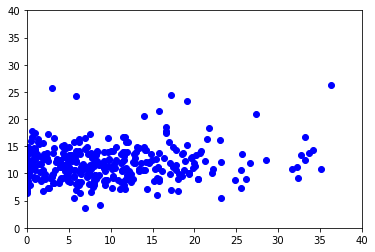

In [1133]:
# 뭐지.. amount_spent를 예측했는데 total spent와 많이 비슷합니다.
g3ex =pd.merge(g3_label,train_label[['acc_id','amount_spent','total_spent']], on = 'acc_id',how='inner')

plt.plot(g3ex['total_spent'],g3ex['amount_spent_x'],'bo')
linreg_RMSE3ex = np.sqrt(mse(g3ex['amount_spent_x'], g3ex['total_spent']))
print(linreg_RMSE3ex)
plt.axis([0, 40, 0, 40]); plt.show()

(array([88., 74., 60., 48., 33., 23.,  7.,  7.,  3.,  7.]),
 array([ 0.        ,  3.63157941,  7.26315881, 10.89473822, 14.52631762,
        18.15789703, 21.78947643, 25.42105584, 29.05263524, 32.68421464,
        36.31579405]),
 <a list of 10 Patch objects>)

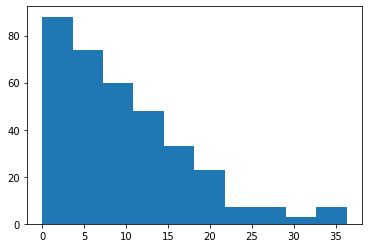

In [1148]:
plt.hist(g3ex['total_spent'])

12.276985832646165


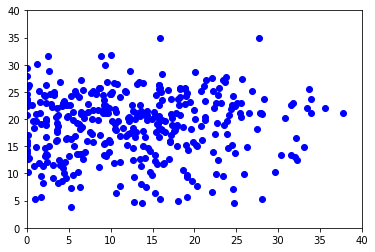

In [1136]:
g4ex =pd.merge(g4_label,train_label[['acc_id','amount_spent','total_spent']], on = 'acc_id',how='inner')
plt.plot(g4ex['total_spent'],g4ex['amount_spent_x'],'bo')
linreg_RMSE4ex = np.sqrt(mse(g4ex['amount_spent_x'], g4ex['total_spent']))
print(linreg_RMSE4ex)
plt.axis([0, 40, 0, 40]); plt.show()

(array([84., 58., 62., 66., 43., 34., 11., 12.,  1.,  2.]),
 array([ 0.        ,  4.47343218,  8.94686435, 13.42029653, 17.8937287 ,
        22.36716088, 26.84059306, 31.31402523, 35.78745741, 40.26088958,
        44.73432176]),
 <a list of 10 Patch objects>)

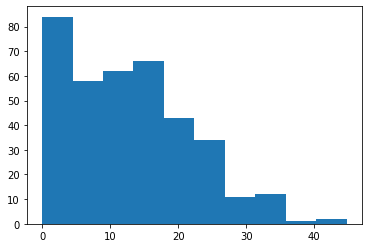

In [1147]:
plt.hist(g4ex['total_spent'])

0.8512732453585782


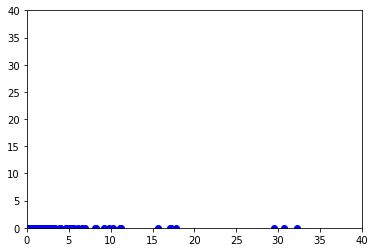

In [1144]:
g1ex =pd.merge(group_1,train_label[['acc_id','amount_spent','total_spent']], on = 'acc_id',how='inner')
plt.plot(g1ex['total_spent'],g1ex['amount_spent_x'],'bo')
linreg_RMSE1ex = np.sqrt(mse(g1ex['amount_spent_x'], g1ex['amount_spent_y']))
print(linreg_RMSE1ex)
plt.axis([0, 40, 0, 40]); plt.show()

In [1161]:
crosscheck_label = pd.merge(crosscheck, train_label[['acc_id','total_spent']], on ='acc_id', how='inner')

In [1162]:
crosscheck_label

,acc_id,pred_spent_0,pred_under_10,pred_under_20,group_1,group_2,group_3,group_4,total_spent
0,106945,0,1,1,0,1,0,0,1.478335
1,53353,0,0,0,0,0,0,1,11.845576
2,92778,0,1,1,0,1,0,0,3.683237
3,22031,0,1,1,0,1,0,0,0.000000
4,87505,1,1,1,1,0,0,0,0.000000
5,119288,1,1,1,1,0,0,0,0.000000
6,40465,0,1,1,0,1,0,0,0.000000
7,96352,0,0,0,0,0,0,1,3.128862
8,61860,1,1,1,1,0,0,0,0.000000
9,101220,0,1,1,0,1,0,0,0.936559
